# Titanic dataset preparation

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data analysis
## Missing Data

In [88]:
train = pd.read_csv('titanic_train.csv')

After loading data we can check if any of the data is missing. We can do this using graph or counting missing values.

<AxesSubplot:>

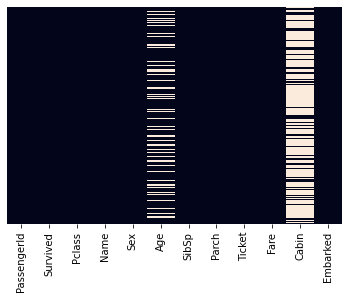

In [89]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False)

In [90]:
train.isna().sum()/train["PassengerId"].count()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

Dataset mising some of Age data and most of Cabin data. There is also one record of Embarked missing.

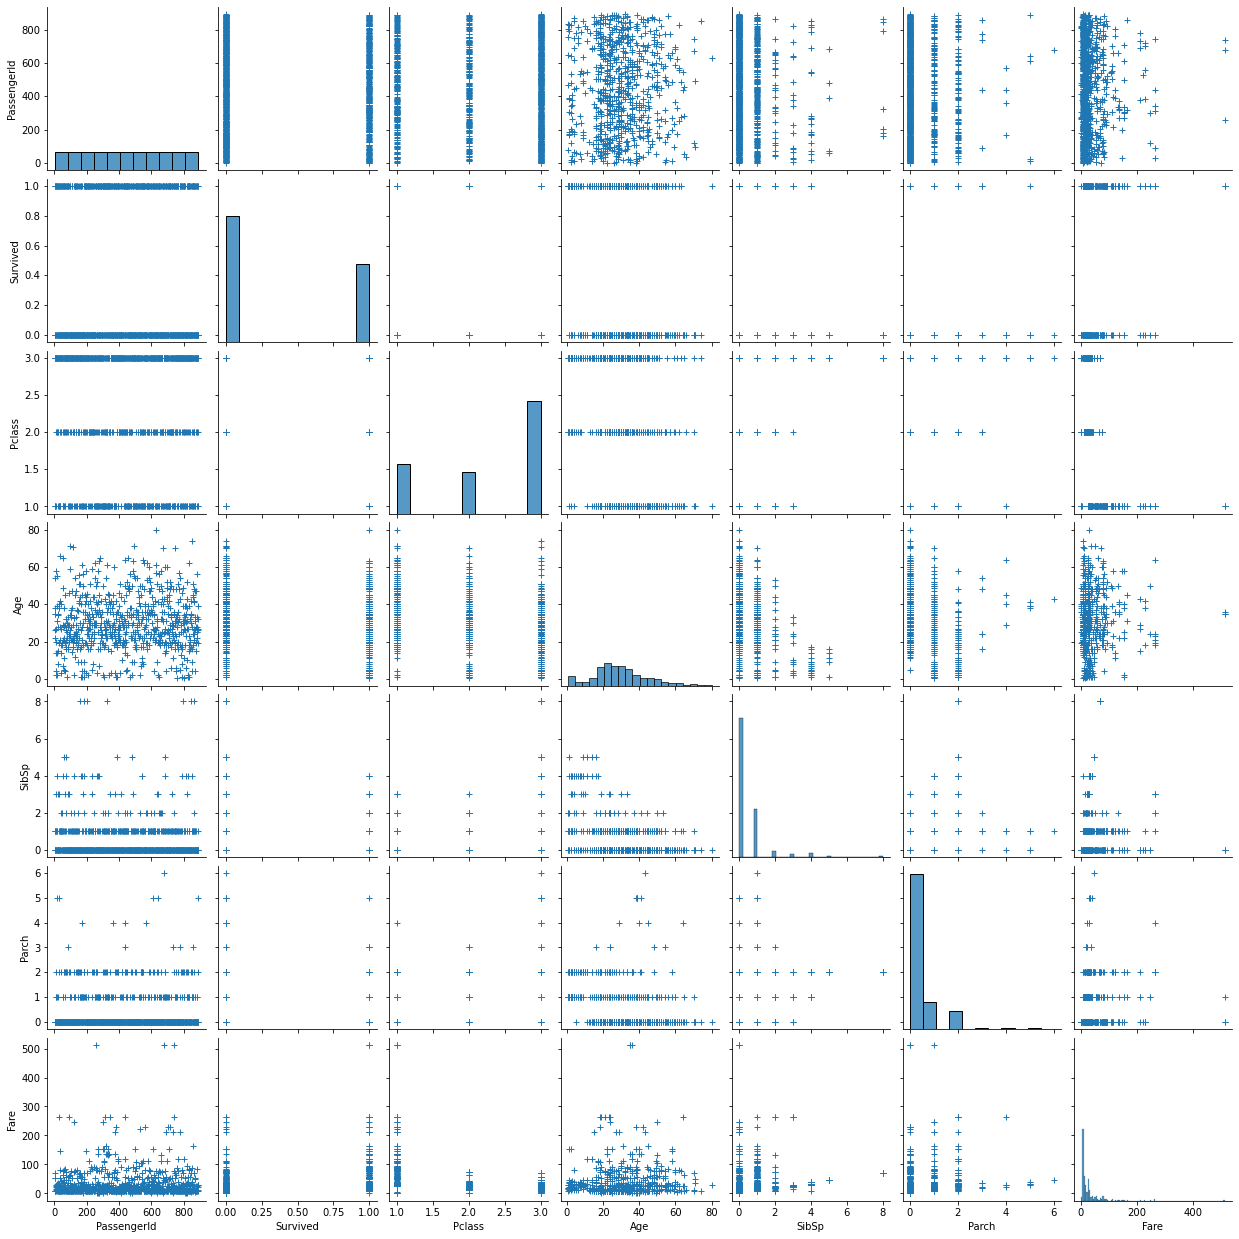

In [91]:
sns.pairplot(train,plot_kws=dict(marker="+", linewidth=1))

There is no obvoius correlation between age and other variables, although we can help ourselves with data description. It's pausoble that class of passenger class is somewhat corelated witch age.


<AxesSubplot:xlabel='Pclass', ylabel='Age'>

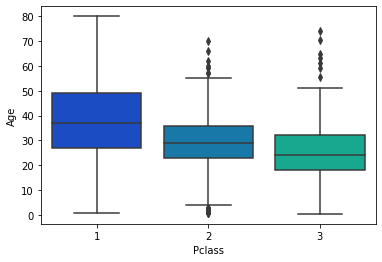

In [92]:
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

The higher class of ticket the higer price is. Older people tend to have more money so it make sense that average age of first class passenger is higher. We can leverage this fact to our benefit.

We could simply fill in mising data with average of existing one. Though the more specific we get with data augmentation, the better starting positin for our model we get. This is not always the case because one can overdo it and introduce too much noise to our data, but i recon this is not the case here.

In [93]:
def fillInAge(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return train[train["Pclass"]==1]["Age"].mean()
        elif Pclass == 2:
            return train[train["Pclass"]==2]["Age"].mean()
        else:
            return train[train["Pclass"]==3]["Age"].mean()
    else:
        return Age

In [94]:
train['Age'] = train[['Age','Pclass']].apply(fillInAge,axis=1)

<AxesSubplot:>

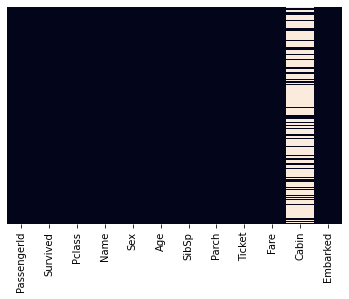

In [95]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False)

We managed to get rid of missing age data. When it comes to Cabin data, we missing plenty of is so for start we can drop that column.

In [96]:
train.drop('Cabin',axis=1,inplace=True)

<AxesSubplot:>

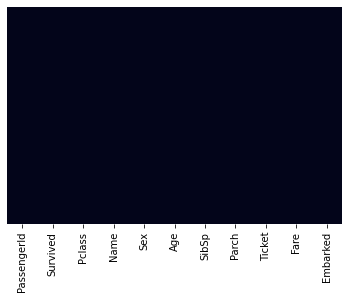

In [97]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False)

Although its not visible on heatmap at the begining we can reacll that there were also missing records in Embarked column

In [98]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

There are only two of those so we can drop them for now

In [99]:
train.dropna(inplace=True)

In [100]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## Non numerical data

There is one more thing we have to do with our data.

In [101]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


As we can see some of the data are nonnumerical; that is Name, Sex, Ticket, Emarked. Let's analyse it.

<AxesSubplot:xlabel='Survived', ylabel='count'>

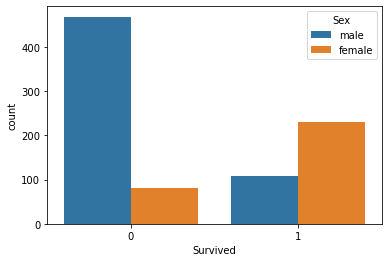

In [102]:
sns.countplot(x='Survived',hue='Sex',data=train)

In [103]:
train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

Out of 4 mentioned columns Sex is quite important for our predictions and there are only two classes in that column. Embarked tell us where port of embarkation (Key: C = Cherbourg, Q = Queenstown, S = Southampton). There are not to many unique valuse so we can create dummy variables out of these.
When it comes to Ticket, it's just a number of ticket so it's potencialy useless for us. We can drop it.

In [104]:
train['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 889, dtype: object

Name is name of passenger. Potencialy we can use this data to extract gender, social status or find out if one of these people is a politician or someone famous. These data can potencialy be usefull in predicting ones survival. However for now we will drop it.

In [105]:
"""
We can use drop_first option while creating dummies, because if one record doesnt melong to any other category, therefore
it must belong to the first one.
""" 
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
train = pd.concat([train,sex,embark],axis=1)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


## Now our data can be used to train model